# ANÁLISIS DE LA IMPORTANCIA DE LAS VARIABLES

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from scipy.stats import mannwhitneyu
%matplotlib inline

### Código para mostrar progreso de la barra
Extraído de https://github.com/alexanderkuk/log-progress

In [2]:
# https://github.com/alexanderkuk/log-progress

def log_progress(sequence, every=None, size=None, name='Items'):
    from ipywidgets import IntProgress, HTML, VBox
    from IPython.display import display

    is_iterator = False
    if size is None:
        try:
            size = len(sequence)
        except TypeError:
            is_iterator = True
    if size is not None:
        if every is None:
            if size <= 200:
                every = 1
            else:
                every = int(size / 200)     # every 0.5%
    else:
        assert every is not None, 'sequence is iterator, set every'

    if is_iterator:
        progress = IntProgress(min=0, max=1, value=1)
        progress.bar_style = 'info'
    else:
        progress = IntProgress(min=0, max=size, value=0)
    label = HTML()
    box = VBox(children=[label, progress])
    display(box)

    index = 0
    try:
        for index, record in enumerate(sequence, 1):
            if index == 1 or index % every == 0:
                if is_iterator:
                    label.value = '{name}: {index} / ?'.format(
                        name=name,
                        index=index
                    )
                else:
                    progress.value = index
                    label.value = u'{name}: {index} / {size}'.format(
                        name=name,
                        index=index,
                        size=size
                    )
            yield record
    except:
        progress.bar_style = 'danger'
        raise
    else:
        progress.bar_style = 'success'
        progress.value = index
        label.value = "{name}: {index}".format(
            name=name,
            index=str(index or '?')
        )

# 1. Carga de los datos

In [3]:
df = pd.read_csv("./data/SerieTotal2016_ext_top100.csv")
df["timestamp"] = pd.to_datetime(df["timestamp"])

In [4]:
horas = [df["timestamp"][i].hour for i in log_progress(np.arange(df.shape[0]))]
df["hour"] = horas

In [5]:
df.head()

,element_key,latitude,longitude,timestamp,paid_parking_area,day_year,occupation_perc,prcp,tmax,tmin,...,baseball,tennis,basket,soccer,event,no2,co,pm2_5,o3,hour
0,1018,47.610756,-122.341899,2016-01-02 08:00:00,Belltown,2,0.00,0.0,5.56,-3.89,...,0,0,0,0,0,71.001333,1030.5,19.875,83.0,8
1,1018,47.610756,-122.341899,2016-01-02 09:00:00,Belltown,2,3.70,0.0,5.56,-3.89,...,0,0,0,0,0,71.001333,1030.5,19.875,83.0,9
2,1018,47.610756,-122.341899,2016-01-02 10:00:00,Belltown,2,18.52,0.0,5.56,-3.89,...,0,0,0,0,0,71.001333,1030.5,19.875,83.0,10
3,1018,47.610756,-122.341899,2016-01-02 11:00:00,Belltown,2,14.81,0.0,5.56,-3.89,...,0,0,0,0,0,71.001333,1030.5,19.875,83.0,11
4,1018,47.610756,-122.341899,2016-01-02 12:00:00,Belltown,2,7.41,0.0,5.56,-3.89,...,0,0,0,0,0,71.001333,1030.5,19.875,83.0,12


# 2. Relevancia de los intervalos de la variable "hora"

Esta sección presenta un análisis de relevancia de los intervalos en los que un vehículo entra a un parquímetro, según el dataset de que se dispone. Ello nos permitirá definir qué intervalos horarios no aportan información estadísticamente significativa a la variable objetivo (porcentaje de ocupación). 

Para realizar este análisis, se segmenta la variable 'hora' en intervalos de la forma 8-9, 9-10, 10-11, ... Cada intervalo está representado por su extremo inferior. Así, '8' representa el intervalo '8h-9h', y '9' representa el intervalo '9h-10h'. Una vez segmentada la variable, se realiza la **prueba U de Mann-Whitney**, bajo la hipótesis nula siguiente:

$$ H_0 : \text{Encontrarse en el rango horario } h_i \; \text{tiene la misma distribución estadística que no encontrarse en él } (\neg h_i) \text{, con relación al porcentaje de ocupación} $$

La prueba U de Mann-Whitney es un test no paramétrico (no impone ninguna condición a la distribución de los datos), basado en suma de rangos. En ella, se calcula el estadístico $U$, definido como:

$$ U = \min(U_1, U_2) $$

$U_1$ y $U_2$ son se calculan como sigue:

$$U_i = R_i -\dfrac{n_i(n_i+1)}{2}, \; i \in \{1,2\} \text{ ,} $$

donde $n_1$ es el número de muestras que corresponden a la hora bajo estudio ($h_i$), mientras que $n_2$ es el número de muestras restantes ($\neg h_i$). $R_i$ es la suma de los rangos correspondiente a cada muestra (*rank sum*). 

Con esta prueba, se ordenan las dos muestras (1 y 2) conjuntamente, en función del valor del porcentaje de ocupación. Si las dos muestras son muy diferentes, $U$ será un valor pequeño, mientras que si son parecidas, $U$ será un valor elevado. 

La **distribución nula** de la prueba corresponde con las probabilidades de obtener un determinado valor de $U$ suponiendo que las dos distribuciones son iguales. Esta distribución se puede aproximar por media gaussiana: $f_X(x) = N(\mu, \sigma)\;, 0 \leq x \leq \mu$, siempre y cuando el número de muestras sea suficiente. Con esta distribución se evalúa la significación asintótica ($p$), como la probabilidad de que el estadístico $U$ sea pequeño, valor que rechazaría la hipótesis nula. 

Una limitación importante a considerar de esta prueba es que las dos muestras ($h_i$ y $\neg h_i$) deben tener distribuciones con formas parecidas. 

Siguiendo el procedimiento habitual, establecemos el nivel de significación en $\alpha = 0.05$. 


In [6]:
len(np.unique(df["element_key"]))

100

## Análisis para varios Element Keys
**Función de relevancia**

Se define a continuación la función de relevancia, que pasa el test U a un parquímetro en concreto, representando la relevancia estadística de cada hora con relación al target (porcentaje de ocupación). 

In [7]:
def relevancia_horas_EK(ek):
    U = list()
    p = list()
    
    horas = np.linspace(8,19,12)
    signif = 0.05*np.ones(len(horas))
    
    for i in log_progress(horas):
        h = df.loc[(df["hour"]==i) & (df["element_key"]==ek), "occupation_perc"]
        neg_h = df.loc[(df["hour"]!=i) & (df["element_key"]==ek), "occupation_perc"]
        U.append(mannwhitneyu(h,neg_h)[0])
        p.append(mannwhitneyu(h,neg_h)[1])
        
    plt.figure(dpi=150)
    bars = plt.bar(horas, p)
    for i in range(len(bars)):
        if p[i]<0.05:
            bars[i].set_color('lawngreen')
        else:
            bars[i].set_color('gray')
            
    plt.plot(horas, signif, color='red')
    plt.yscale('log')
    plt.xticks(horas)
    plt.ylabel("$p$ value")
    plt.xlabel("Hours")
    plt.title("EK " + str(ek))
    _ = plt.show

A continuación, se analiza la relevancia estadística de algunos EKs. Puede observarse que, estadísticamente, no todos tienen la misma calidad para alimentar un modelo predictivo. 

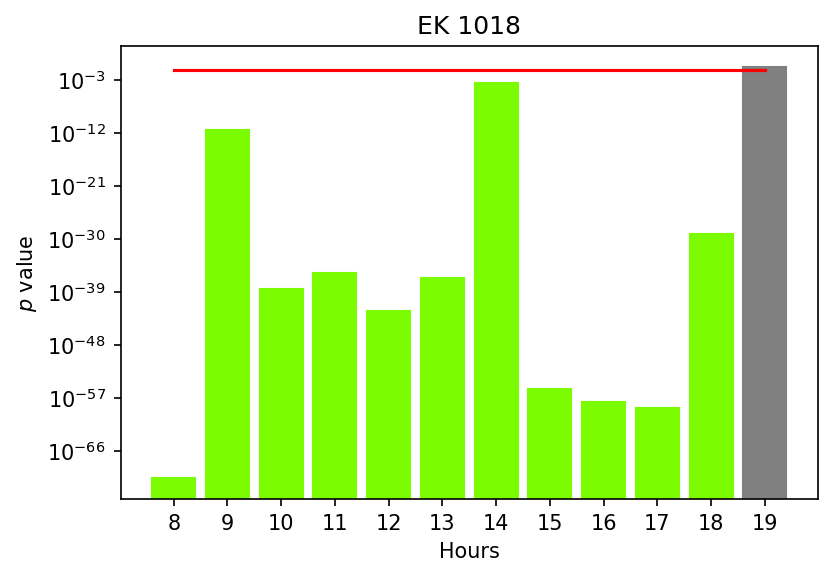

In [8]:
relevancia_horas_EK(1018)

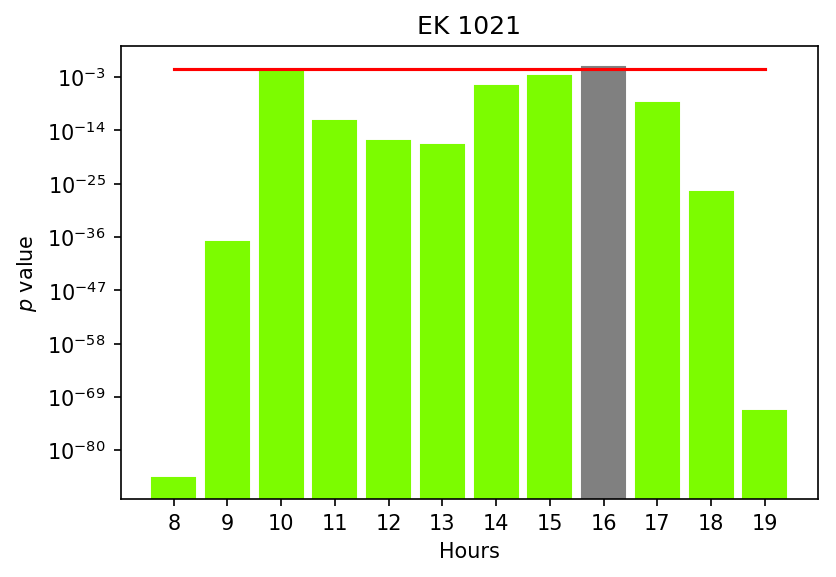

In [9]:
relevancia_horas_EK(1021)

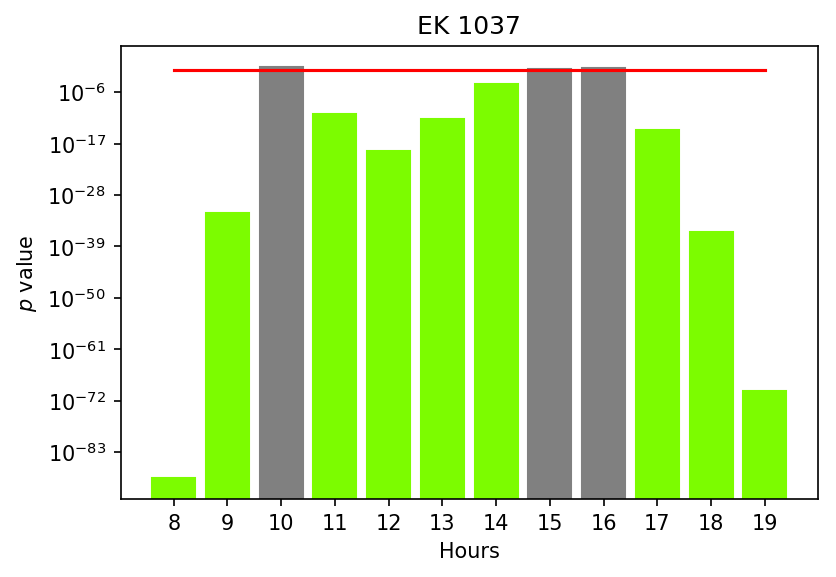

In [10]:
relevancia_horas_EK(1037)

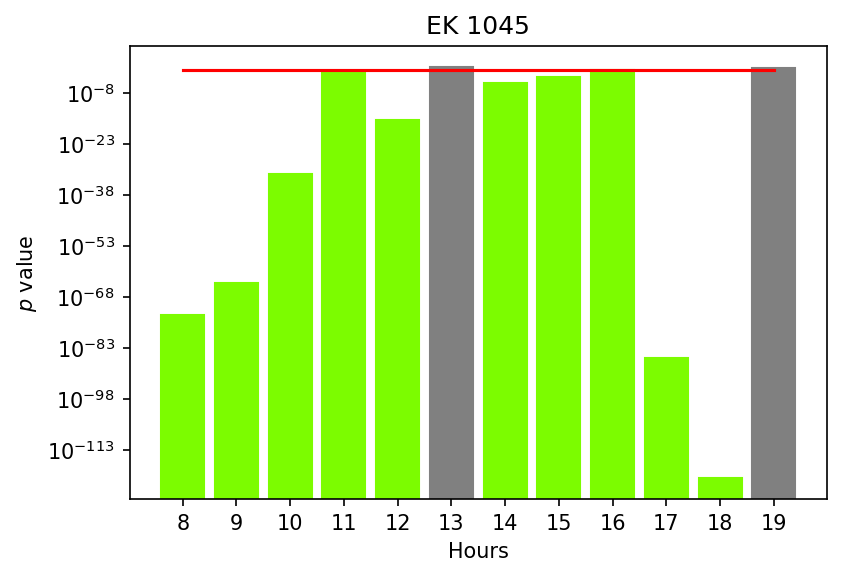

In [11]:
relevancia_horas_EK(1045)

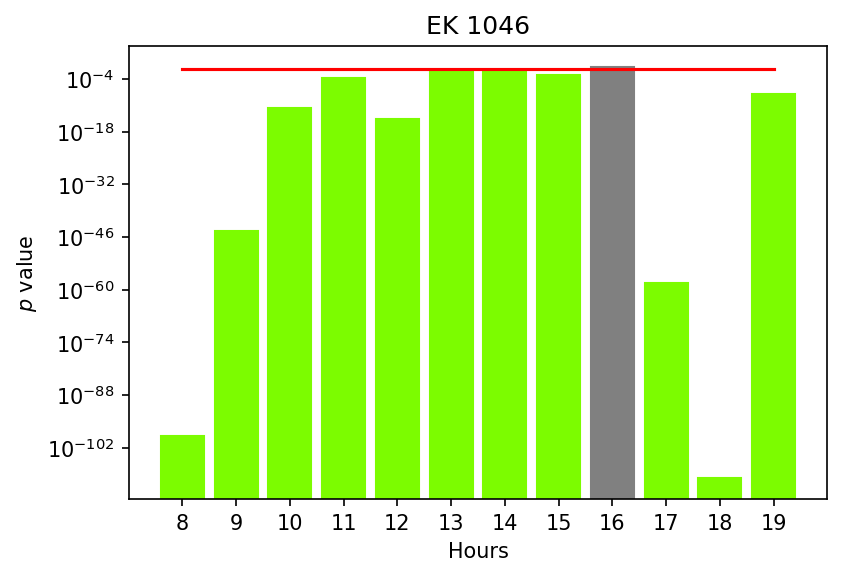

In [12]:
relevancia_horas_EK(1046)

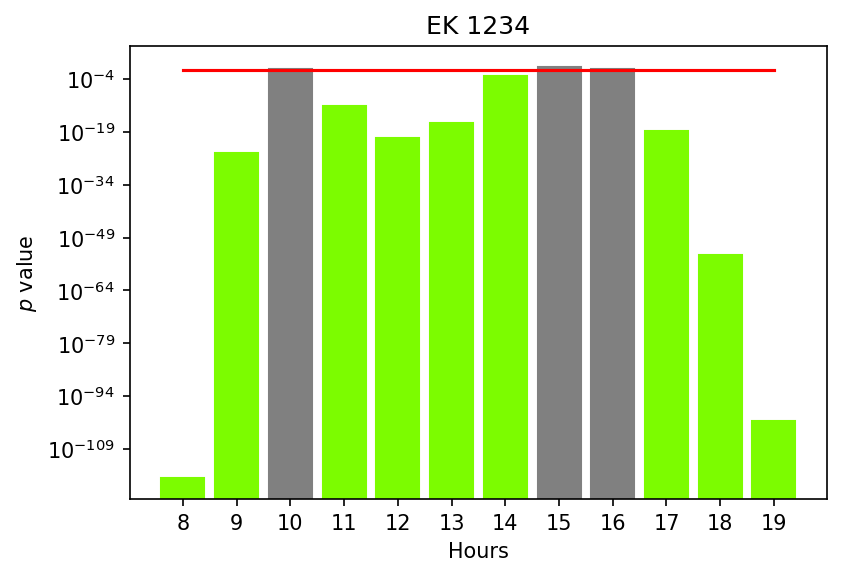

In [13]:
relevancia_horas_EK(1234)

# 3. Importancia de las covariables (regresores)

Esta sección analiza, mediante varios métodos, la importancia de las covariables (regresores) del dataset. Dado que hay distintos tipos de variables, realizaremos una prueba diferente para cada una de ellas. En concreto:
* Variables continuas: se compara una variable continua con el target (variable continua). Test: Correlación de Pearson
* Variables binarias: se compara una variable binaria con el target (variable continua). Test: U Mann-Whitney

En primer lugar definimos los tipos de variables:

In [14]:
continuas = ["prcp", "tmax", "tmin", "air_temp", "road_temp", "no2", "co", "pm2_5", "o3"]
binarias = ["poi", "baseball", "tennis", "basket", "soccer", "event"]

## Variables continuas
Son lecturas de sensores acerca de las condiciones atmosféricas y de temperatura. Se les aplica un test de correlación de pearson. Utilizaremos las siguientes reglas para calibrar el significado del coeficiente de correlación ($\rho$):

* $0.0\leq \left|\,\rho\,\right|<0.3$: correlación *débil*
* $0.3\leq \left|\,\rho\,\right| < 0.7$: correlación *moderada* 
* $0.7\leq \left|\,\rho\,\right| \leq 1.0$: correlación *fuerte* 

Si la correlación es moderada o fuerte, el signo de $\rho$ nos indicará el sentido de la correlación (directa o inversa).

El nivel de significación se establece en $\alpha=0.05$. Se marcan en gris las variables cuya significación asintótica es menor que el nivel de significación.

In [15]:
def relevancia_continuas(ek):
    r = list()
    p = list() 
    
    for varcont in continuas:
        _r = pearsonr(df.loc[df["element_key"]==ek, varcont], df.loc[df["element_key"]==ek, "occupation_perc"])
        r.append(_r[0])
        p.append(_r[1])
    plt.figure(dpi=150)
    bars = plt.bar(continuas, r)
    plt.xticks(rotation=90)
    plt.ylabel("Pearson r")
    for i in range(len(bars)):
        if p[i]<0.05:
            bars[i].set_color('lawngreen')
        else:
            bars[i].set_color('gray')
    plt.title("EK " + str(ek))

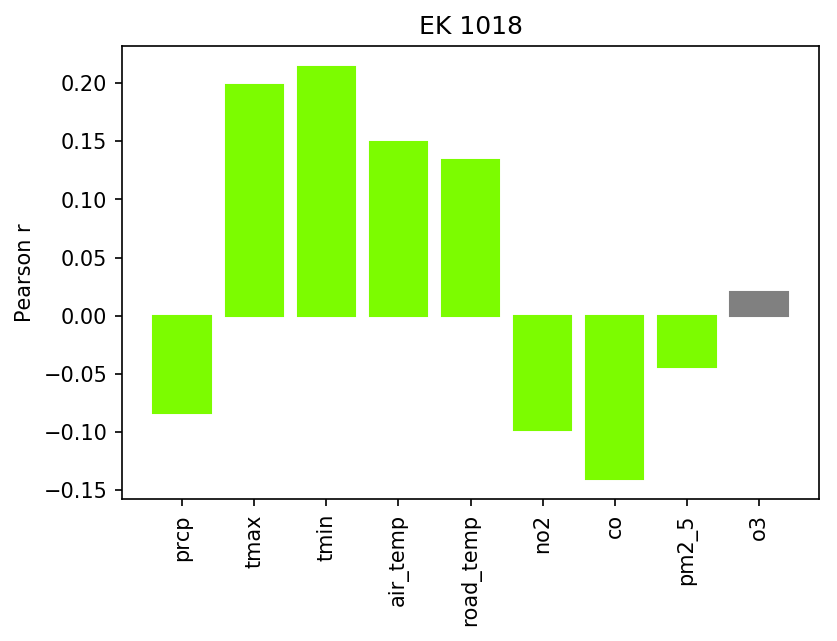

In [16]:
relevancia_continuas(1018)

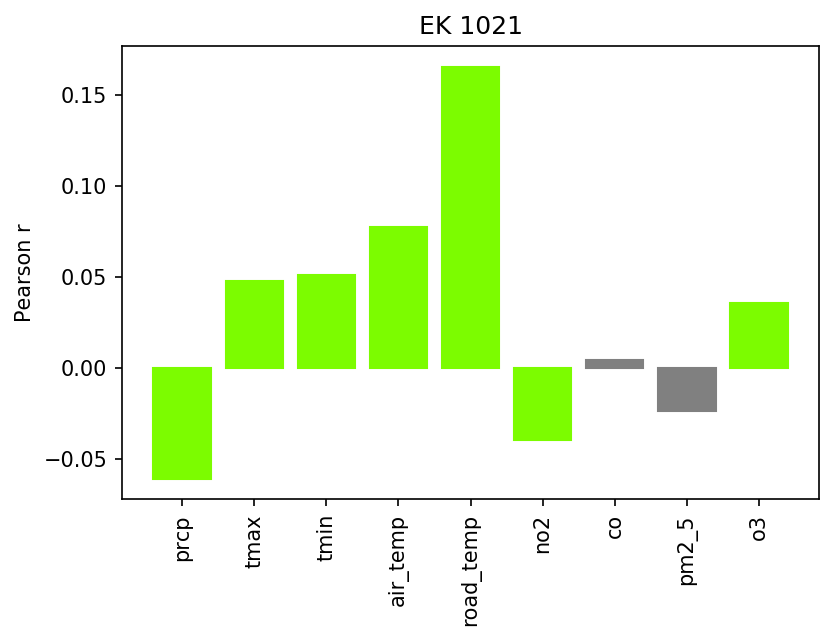

In [17]:
relevancia_continuas(1021)

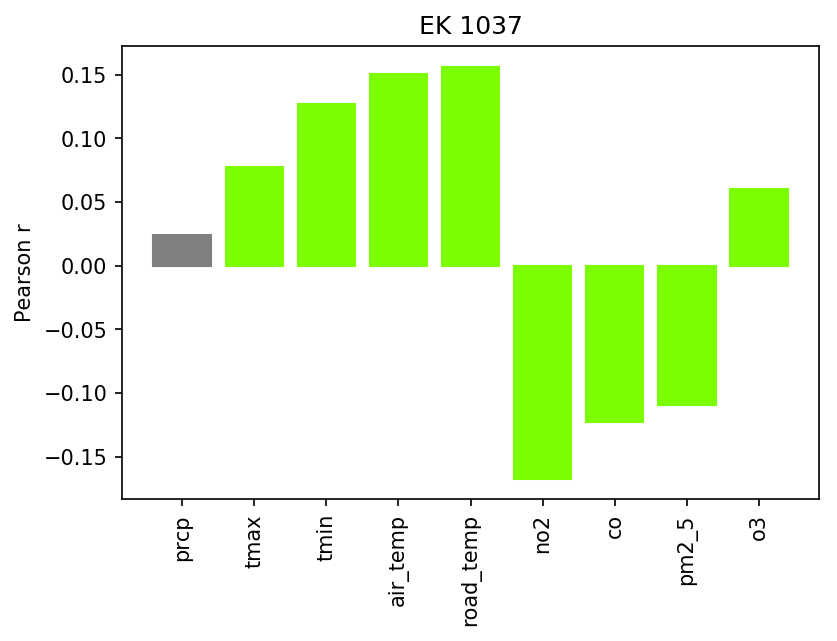

In [18]:
relevancia_continuas(1037)

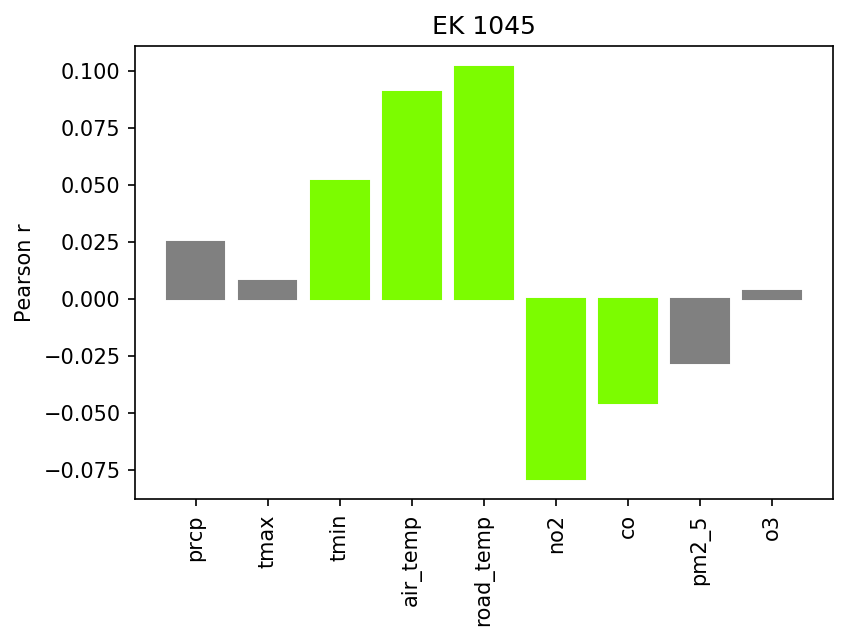

In [19]:
relevancia_continuas(1045)

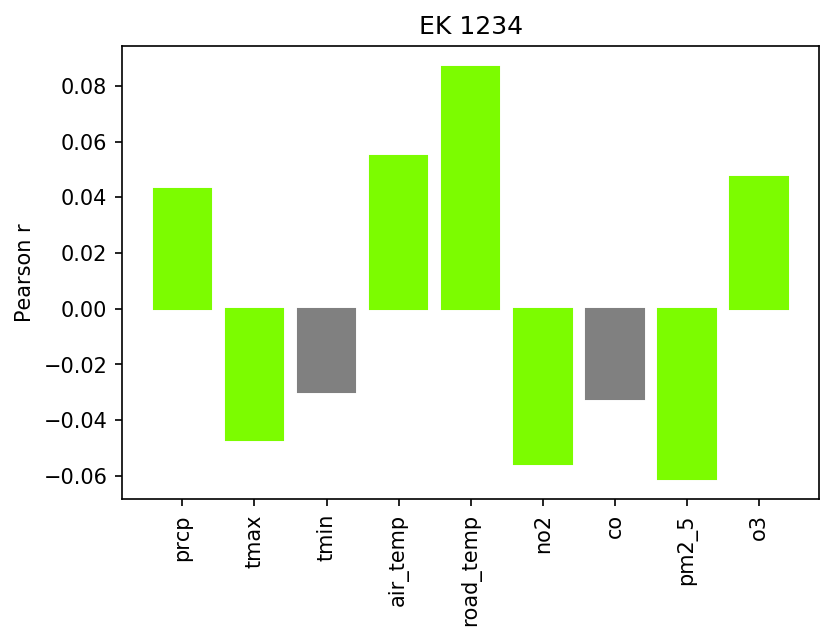

In [20]:
relevancia_continuas(1234)

Hay mucha variabilidad pero, como conclusión general, se puede extraer que para algunos parquímetros hay una correlación entre débil y moderada de las variables de temperatura con el porcentaje de ocupación ($p<0.05$).

## Variables binarias
Este análisis únicamente es relevante si se tienen en cuenta varios Element Keys. Si solo se analiza un EK aislado, entonces todas estas variables son constantes y por tanto no aportan información. Por ello, para este cálculo, se consideran todos los EK. 

Se realiza la prueba U de Mann-Whitney a cada una de las variables binarias, representando su significación asintótica. 

In [21]:
# Son siempre 0 en el dataset
binarias.remove("soccer")
binarias.remove("event")

In [22]:
def relevancia_binarias():
    U = list()
    p = list()
        
    for varbin in binarias:
        h = df.loc[df[varbin]==1, "occupation_perc"]
        neg_h = df.loc[df[varbin]==0, "occupation_perc"]
        U.append(mannwhitneyu(h,neg_h)[0])
        p.append(mannwhitneyu(h,neg_h)[1])
        
    plt.figure(dpi=150)
    bars = plt.bar(binarias, p)
    for i in range(len(bars)):
        if p[i]<0.05:
            bars[i].set_color('lawngreen')
        else:
            bars[i].set_color('gray')          
    plt.ylabel("$p$ value")
    plt.yscale('log')

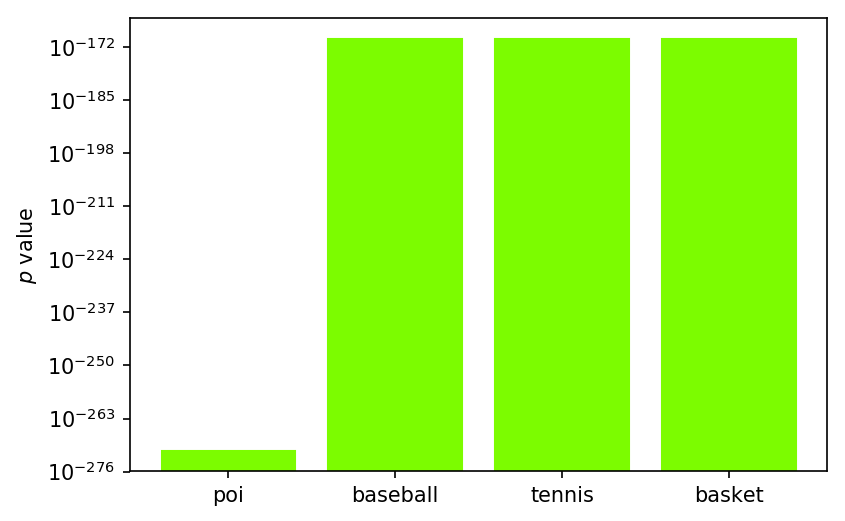

In [23]:
relevancia_binarias()

# 4. Conclusiones

* Para cada EK, la gran mayoría de las horas son relevantes aunque el grado de significación y número de horas relevantes  varían de un EK a otro (p<0.05).
* Los regresores continuos presentan un nivel de correlación débil con el porcentaje de ocupación (p<0.05).
* Los regresores binarios tienen mayor importancia que los regresores continuos (p<0.05), pero exigen que se utilice más de un EK en la predicción.
